<a href="https://colab.research.google.com/github/tomaru5963/colab/blob/master/CartPole_wQLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install gym

.........1000, ave=183.915
.........2000, ave=183.23
.........3000, ave=185.51
.........4000, ave=187.47
.........5000, ave=189.265
.........6000, ave=187.485
.........7000, ave=184.615
.........8000, ave=188.525
.........9000, ave=179.225
.........10000, ave=183.925


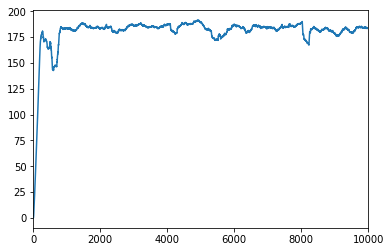

In [4]:
import collections

import numpy as np
import pandas as pd
import gym

NUM_EPISODES = 10000
RESOLUTION = 10
ALPHA = 0.1
GAMMA = 0.5
# GAMMA = 0.9
EPSILON = 0.0001

class QLearning(object):
    def __init__(self, env):
        shape = [RESOLUTION] * env.observation_space.shape[0]
        shape.append(env.action_space.n)
        self.num_actions = env.action_space.n
        self.q_table = np.zeros(shape)
        # self.q_table = np.random.random_sample(shape)

        self.bins = []
        for l, h in zip(env.observation_space.low, env.observation_space.high):
            self.bins.append(np.linspace(l, h, RESOLUTION + 1)[1:-1])

        self.last_action_inds = None

    def digitize(self, observation):
        inds = []
        for v, a in zip(observation, self.bins):
            inds.append(np.searchsorted(a, v))
        return tuple(inds)

    def get_action(self, observation, reward, done):
        inds = self.digitize(observation)
        if np.random.random() < EPSILON:
            action = np.random.randint(self.num_actions)
        else:
            action = self.q_table[inds].argmax()
        # print(observation, reward, done)
        if self.last_action_inds:
            self.q_table[self.last_action_inds] = (
                (1 - ALPHA) * self.q_table[self.last_action_inds] +
                ALPHA * (reward + GAMMA * self.q_table[inds].max()))
        if done:
            self.last_action_inds = None
        else:
            inds = list(inds)
            inds.append(action)
            self.last_action_inds = tuple(inds)
        return action

rewards = collections.deque([0], 200)
avgs = []
over195s = 0
env = gym.make('CartPole-v0')
q_learning = QLearning(env)

for episode in range(1, NUM_EPISODES + 1):
    rewards.append(0)
    observation = env.reset()
    action = q_learning.get_action(observation, None, None)

    for step in range(1, 201):
        # action = env.action_space.sample()
        # env.render()
        observation, reward, done, _ = env.step(action)
        rewards[-1] += reward
        
        if step >= 195:
            reward = 1
        elif done:
            reward = -1
        else:
            reward = 0
        action = q_learning.get_action(observation, reward, done)

        if done:
            break
    avgs.append(sum(rewards) / rewards.maxlen)
    if avgs[-1] >= 195:
        over195s += 1
        if over195s > 100:
            print(f'Greater than or equal to 195 avg at episode {episode}')
            break
    else:
        over195s = 0

    if episode % 1000 == 0:
        print(f'{episode}, ave={avgs[-1]}')
    elif episode % 100 == 0:
        print('.', end='')

pd.Series(avgs).plot()
# print(q_learning.q_table)